# Selection Bias Correction

Let $T(x)$ be the biased black-box selection process for labelling data at DOHMH.

Let $U$ be the set of all Yelp Reviews that have been processed by the system.

Let $B \subset U$ s.t. $B = \{(x,y) | T(x) = 1\}$ and $B^c \subseteq U \setminus B$

### Training: Error Rate

We can model the error rate of some classifier $f$ as:

$p(f(x) \neq y) = \Sigma_{t}{p( f(x) \neq y | T(x) = t)p(T(x)=t)}$

and use plugin estimates:

$\hat{p}(T(x) = 1) = \frac{|B|}{|U|}$ (the % of labeled points)

$\hat{p}(f(x) \neq y | T(x)=1) = \frac{1}{|B|}\Sigma_{(x,y) \in B}{I[f(x) \neq y]}$

likewise,

$\hat{p}(f(x) \neq y | T(x)=0) = \frac{1}{|B^c|}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

therefore

$\hat{p}(f(x) \neq y) = w_B\Sigma_{(x,y) \in B}{I[f(x) \neq y]} + w_{B^c}\Sigma_{(x,y) \in B^c}{I[f(x) \neq y]}$

where 

$w_B = \frac{1}{|U|}$ and $w_{B^c} = (1 - \frac{|B|}{|U|})(\frac{1}{|B^c|})$

Note that when $B^c$ is the entire complement of $B$, then $w_{B^c}$ reduces to $\frac{1}{|U|}$

So, if we are trying to minimize the classification error in the objective function (which cross entropy does) then these are the sample weights to be used when calculating the error

### Testing: Area Under Precision-Recall Curve

We will evaluate models using the AUPR metric, calculated empirically on the dev and test sets.

This metric is appropriate because of the major positive-class imbalance in the dataset (estimated to be.7%).

The tricky thing is that our measures of precision and recall need to also be importance weighted, and the importance weights for precision will vary as we vary the threshold.

To see why, consider the probabilistic form of precision for some classifier $f$:

#### Precision

Let $U$ be the test set.

$Precision = p(y=1|f(x)=1) = \Sigma_{t}{p(y=1 | f(x)=1, T(x) = t)p(T(x)=t|f(x)=1)}$

Let $U_P \subset U$ be the set $\{(x,y) | f(x) = 1\}$. 

**Note** that $U_P$ varies with the classification threshold.

Then as with the error rate, we can find plugin estimates for the necessary quanities.

$\hat{p}(T(x) = 1|f(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B}{I[f(x)=1]} = \frac{|B \cap U_P|}{|U_P|}$

and so $\hat{p}(T(x) = 0|f(x)=1) = 1 - \frac{|B \cap U_P|}{|U_P|}$

Also,

$\hat{p}(y=1|f(x)=1, T(x)=1) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
 $

and $\hat{p}(y=1|f(x)=1, T(x)=0) = \frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

Therefore

$Precision = \frac{|B \cap U_P|}{|U_P|} \frac{1}{|U_P|} \Sigma_{(x,y) \in B\cap U_P}{I[y=1]} 
+ (1 - \frac{|B \cap U_P|}{|U_P|})\frac{1}{|U_P|} \Sigma_{(x,y) \in B^c\cap U_P}{I[y=1]}$

#### Recall

The derivation for improtance-weighted (IW) recall follows similary to IW precision.

$Recall = p(f(x)=1|y=1) = \Sigma_{t}{p(f(x)=1| y=1, T(x) = t)p(T(x)=t|y=1)}$

Let $U_R \subset U$ be the set $\{(x,y) | y = 1\}$. 

**Note** that $U_R$ **does not** vary with the classification threshold.

The plugin estimates are:

$\hat{p}(T(x) = 1|y=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B}{I[y=1]} = \frac{|B \cap U_R|}{|U_R|}$

and so $\hat{p}(T(x) = 0|y=1) = 1 - \frac{|B \cap U_R|}{|U_R|}$

Also,

$\hat{p}(f(x)=1 |y=1, T(x)=1) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}$

and $\hat{p}(f(x)=1|y=1, T(x)=0) = \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

plugging in we have

$ Recall =  \frac{|B \cap U_R|}{|U_R|} \frac{1}{|U_R|} \Sigma_{(x,y) \in B\cap U_R}{I[f(x)=1]}
+ (1 - \frac{|B \cap U_R|}{|U_R|}) \frac{1}{|U_R|} \Sigma_{(x,y) \in B^c\cap U_R}{I[f(x)=1]}$

#### AUPR Curve

Finally, using the above plugin estimates, we can balance data from both $B$ and (a sample from) $B^c$.  We can obtain a series of ordered Precision-Recall points $E = \{(p,r,t)_i | r_i \leq r_{i'}\}$ by varying the classification threshold $t \in [0,1]$ and then using trapezoidal integration to approximate the area under the Recall vs. Precision curve.

#### Bootstrap

For the final evaluation, we would like confidence intervals about the AUPR. We find these by using the percentile bootstrap:

We calculate bootstrap statistics for the IW-AUPR as follows:

First we calculate the test data IW-AUPR. Call this $\bar{x}$.

Then we resample the test dataset with replacement $B$ times and obtain the IW-AUPR estimates for each set.

Call these $x_1, ...,  x_B$.

Then we can compute confidence intervals around $\bar{x}$ the usual way by finding the $\alpha=.025$ boundary quantiles $\delta_{\alpha}, \delta_{1-\alpha}$, such that 

$$P(\bar{x}^* - \delta_{1-\alpha} \leq \bar{x} \leq \bar{x}^* - \delta_{\alpha}) = .95$$

# TODO

* [X] Take the historical unbiased data and check if any of it is in the biased data. Replace all that are.
* [X] Setup datasets from the two training regimes
* [X] Preprocess datasets for the baselines (scikit models)
* [X] Code up IW objective function for baselines
* [X] Quick test training of baselines
* [X] Code up the dev AUPR evaluation metric.
* [X] Batch out 100 random search cross-validated hyperparam experiments for the RF, SVM, and LR baselines
* [X] Implement the CNN
* [X] Batch out 100 random search early-stopping hyperparam experiments for CNN
* [X] Finish up the viz for chainer monitor
* [ ] Implement the DyCNN
* [ ] Redraft paper
* [ ] Get official test results

## Official Test Results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import itertools
from pprint import pprint

import numpy as np
import numpy.random as npr
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

In [3]:
from experiments.baseline_experiment_util import calc_train_importance_weights
from experiments.baseline_experiment_util import importance_weighted_precision_recall, importance_weighted_pr_curve
from experiments.baseline_experiment_util import setup_baseline_data, area_under_pr_curve
from sklearn.metrics import confusion_matrix

In [4]:
from experiments.lr_model import model as lr_model
from experiments.rf_model import model as rf_model
from experiments.svm_model import model as svm_model
from sklearn.externals import joblib

In [5]:
biased_data = setup_baseline_data(data_path='data', train_regime='biased', test_regime='gold', random_seed=0)
gold_data = setup_baseline_data(data_path='data', train_regime='gold', test_regime='gold', random_seed=0)
silver_data = setup_baseline_data(data_path='data', train_regime='silver', test_regime='gold', random_seed=0)

experiments/baseline_experiment_util.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  old_biased['is_foodborne'] = old_biased['is_foodborne'].map({'Yes':1, 'No':0})
experiments/baseline_experiment_util.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_biased['is_foodborne'] = new_biased['is_foodborne'].map({'Yes':1, 'No':0})
experiments/baseline_experiment_util.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [50]:
# train setup
biased_text = np.array(biased_data['train_data']['text'])
biased_sick = np.array(biased_data['train_data']['is_foodborne'])
biased_mult = np.array(biased_data['train_data']['is_multiple'])
biased_weights = calc_train_importance_weights(biased_data['train_data']['is_biased'], biased_data['U'])

gold_text = np.array(gold_data['train_data']['text'])
gold_sick = np.array(gold_data['train_data']['is_foodborne'])
gold_mult = np.array(gold_data['train_data']['is_multiple'])
gold_weights = calc_train_importance_weights(gold_data['train_data']['is_biased'], gold_data['U'])

silver_text = np.array(silver_data['train_data']['text'])
silver_sick = np.array(silver_data['train_data']['is_foodborne'])
silver_mult = np.array(silver_data['train_data']['is_multiple'])
silver_weights = calc_train_importance_weights(silver_data['train_data']['is_biased'], silver_data['U'])

# test setup
test_data = gold_data['test_data']
B = 1000 # number of bootstrap test set resamples
random_seed = 0
all_results = {}

In [7]:
def f1(precision, recall):
    return 2.*precision*recall/(precision+recall+1e-15)

def iw_bootstrap_score_ci(trues, preds, is_biased, scoring_func, 
                          B=1000, confidence_level=.99, 
                          random_seed=None,
                          **scoring_func_kwds):
    """ Compute a bootstrapped estimate of the importance weighted model score and stratified resampling.
    
    An intuitive and practical guide to bootstrap estimation:
    https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading24.pdf
    """
    if random_seed: npr.seed(random_seed)
    xbar = scoring_func(trues, preds, is_biased, **scoring_func_kwds)
    samples = []
    biased_idxs = np.argwhere(is_biased).ravel()
    nonbiased_idxs = np.argwhere(~is_biased).ravel()
    print
    for i in range(B):
        print '\rB: {}/{}'.format(i,B),
        if len(nonbiased_idxs):
            sample = np.hstack([npr.choice(biased_idxs, len(biased_idxs)), 
                                npr.choice(nonbiased_idxs, len(nonbiased_idxs))])
        else:
            sample = npr.choice(biased_idxs, len(biased_idxs))
        samples.append(scoring_func(trues[sample], preds[sample], is_biased[sample], **scoring_func_kwds))
    diffs = [ xbar - xi for xi in samples]
    alpha = (1. - confidence_level)/2.
    ci_bottom = xbar - np.percentile(diffs, 100.*(1-alpha))
    ci_top = xbar - np.percentile(diffs, 100.*alpha)
    return xbar, ci_bottom, ci_top, samples

def bootstrap_f1_ci(trues, preds, is_biased, random_seed=None, **bootstrap_kwds):
    def scorer(trues, preds, is_biased):
        p, r = importance_weighted_precision_recall(trues, preds, is_biased, threshold=.5)
        return f1(p,r)
    return iw_bootstrap_score_ci(trues, preds, is_biased, scorer,
                              random_seed=random_seed,
                              **bootstrap_kwds)

def bootstrap_aupr_ci(trues, preds, is_biased, random_seed=None, **bootstrap_kwds):
    def scorer(trues, preds, is_biased):
        ps, rs, ts = importance_weighted_pr_curve(trues, preds, is_biased, n_thresholds=50)
        return area_under_pr_curve(ps, rs)
    return iw_bootstrap_score_ci(trues, preds, is_biased, scorer,
                              random_seed=random_seed,
                              **bootstrap_kwds)

In [8]:
def subplot_confusion_matrix(cm, classes, 
                             fig, ax,
                             precision=None, recall=None, f1_ci=None,
                             normalize=False,
                             title='Confusion matrix',
                             cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Modified from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    xlabel = 'Predicted label'
    if (precision is not None) and (recall is not None):
        xlabel += '\nPrecision: {0:2.3f}, Recall: {1:2.3f}'.format(precision, recall)
    if f1_ci is not None:
        xlabel +='\nF1: {0:2.3f}, CI:({1:2.3f}, {2:2.3f})'.format(*f1_ci)
    ax.set_xlabel(xlabel)
    ax.grid(False)

def model_report(model, title, label_key, save_fname=None, test_data=test_data, **bootstrap_kwds):
    y_trues = np.array(test_data[label_key])
    is_biased = np.array(test_data['is_biased'])
    y_preds = model.predict(test_data['text'])
    y_pred_probs = model.predict_proba(test_data['text'])[:,1]
    ps, rs, ts = importance_weighted_pr_curve(y_trues, y_pred_probs, is_biased)
    aupr, aupr_ci_bottom, aupr_ci_top, samples = bootstrap_aupr_ci(y_trues, y_pred_probs, is_biased, **bootstrap_kwds)
#     print '--- {} ---'.format(title)
#     print '  Precision@.5, Recall@.5: {0:2.2f}, {1:2.2f}'.format(precision, recall)
#     print '  AUPR: {0:2.2f}'.format(aupr)
    fig, axs = plt.subplots(2,2, figsize=(8,8))
    axs[0,0].plot(rs, ps, label='AUPR: {0:2.3f} CI=({1:2.3f}, {2:2.3f})'.format(aupr, aupr_ci_bottom, aupr_ci_top))
    axs[0,0].set_title('Precision Recall Curve')
    axs[0,0].set_xlabel('Recall')
    axs[0,0].set_ylabel('Precision')
    axs[0,0].legend(loc=8)
    
    # plot out cms for mixed, biased, and nonbiased
    precision_m, recall_m = importance_weighted_precision_recall(y_trues, y_pred_probs, is_biased, .5)
    f1_ci_m = bootstrap_f1_ci(y_trues, y_pred_probs, is_biased, **bootstrap_kwds)
    cm = confusion_matrix(y_trues, y_preds)
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[0,1], 
                             title='Mixed Bias',
                             precision=precision_m, recall=recall_m, f1_ci=f1_ci_m[:3])
    # biased
    precision_b, recall_b = importance_weighted_precision_recall(y_trues[is_biased], 
                                                             y_pred_probs[is_biased], 
                                                             is_biased[is_biased], .5)
    f1_ci_b = bootstrap_f1_ci(y_trues[is_biased], y_pred_probs[is_biased], is_biased[is_biased], **bootstrap_kwds)
    cm = confusion_matrix(y_trues[is_biased], y_preds[is_biased])
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[1,0], 
                             title='Biased',
                             precision=precision_b, recall=recall_b, f1_ci=f1_ci_b[:3])
    # nonbiased
    # there is no point to reporting precision, recall here since there are no positives
    # but we do it anyways in case the dataset were to change
    precision, recall = importance_weighted_precision_recall(y_trues[~is_biased], 
                                                             y_pred_probs[~is_biased], 
                                                             is_biased[~is_biased], .5)
#     f1_ci = bootstrap_f1_ci(y_trues[~is_biased], y_pred_probs[~is_biased], is_biased[~is_biased], **bootstrap_kwds)
    cm = confusion_matrix(y_trues[~is_biased], y_preds[~is_biased])
    subplot_confusion_matrix(cm, ['Not Sick', 'Sick'], fig, axs[1,1], 
                             title="Nonbiased (all No's)",
                             precision=precision, recall=recall)
    
    
    
    fig.suptitle(title + ' Test Report', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    if save_fname:
        plt.savefig(save_fname+'_report.pdf')
    
    # also plot the bootstrap historgrams to make sure they look ok
    fig2, axs2 = plt.subplots(1,3, figsize=(12,4))
    axs2[0].hist(samples, bins=100)
    axs2[0].axvline(aupr, color='red')
    axs2[0].axvspan(aupr_ci_bottom, aupr_ci_top, alpha=.25, color='red')
    axs2[0].set_title('AUPR Bootstrap')
    axs2[1].hist(f1_ci_m[3], bins=100)
    axs2[1].axvline(f1_ci_m[0], color='red')
    axs2[1].axvspan(f1_ci_m[1], f1_ci_m[2], alpha=.25, color='red')
    axs2[1].set_title('Mixed Bias F1 Boostrap')
    axs2[2].hist(f1_ci_b[3], bins=100)
    axs2[2].axvline(f1_ci_b[0], color='red')
    axs2[2].axvspan(f1_ci_b[1], f1_ci_b[2], alpha=.25, color='red')
    axs2[2].set_title('Biased F1 Boostrap')
    fig2.suptitle(title + ' Bootstrap Histograms', fontsize=14)
    fig2.tight_layout()
    fig2.subplots_adjust(top=0.85)
    if save_fname:
        plt.savefig(save_fname+'_bootstrap_hists.pdf')
        
    return {
        'aupr':aupr,
        'aupr_ci':(aupr_ci_bottom, aupr_ci_top),
        'aupr_samples':samples,
        'mixed_precision':precision_m,
        'mixed_recall':recall_m,
        'mixed_f1':f1_ci_m[0],
        'mixed_f1_ci':f1_ci_m[1:3],
        'mixed_f1_samples':f1_ci_m[3],
        'biased_precision':precision_b,
        'biased_recall':recall_b,
        'biased_f1':f1_ci_b[0],
        'biased_f1_ci':f1_ci_b[1:3],
        'biased_f1_samples':f1_ci_b[3]
    }
        
def print_model_hyperparams(model, name):
    useful_params = {k:v for k,v in model.get_params().items() if '__' in k}
    print "*** {} Hyperparameters ***".format(name)
    pprint(useful_params)

## Sick Task

Here are the notable stats for testing on the Sick task:
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews are have `No` labels
* The 1975 biased reviews are about 52% `Yes`/`No` (1026/949)

In [9]:
pd.Series(test_data['is_foodborne']).value_counts(dropna=False)

0    2026
1     949
dtype: int64

In [10]:
pd.Series(test_data['is_biased']).value_counts(dropna=False)

True     1975
False    1000
dtype: int64

### Logistic Regression

In [11]:
best_sick_lr_biased = joblib.load('experiments/best_models/best_lr_sick_biased.pkl')
best_sick_lr_gold = joblib.load('experiments/best_models/best_lr_sick_gold.pkl')
best_sick_lr_silver = joblib.load('experiments/best_models/best_lr_sick_silver.pkl')

/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator P

In [12]:
best_sick_lr_biased.fit(biased_text, biased_sick, logreg__sample_weight=biased_weights)
best_sick_lr_gold.fit(gold_text, gold_sick, logreg__sample_weight=gold_weights)
best_sick_lr_silver.fit(silver_text, silver_sick, logreg__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.92876195959267271, max_features=None,
        min_df=1, ngram_range=(1, 3), preprocessor=None, stop_words...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [ ]:
start = time.time()
title = 'Logistic Regression Sick Biased'
all_results[title] = model_report(best_sick_lr_biased, title, 'is_foodborne',
                                  save_fname='figures/sick_lr_biased',
                                  B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))


B: 139/1000

In [ ]:
start = time.time()
title = 'Logistic Regression Sick Gold'
all_results[title] = model_report(best_sick_lr_gold, title, 'is_foodborne', 
                                   save_fname='figures/sick_lr_gold',
                                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Logistic Regression Sick Silver'
all_results[title] = model_report(best_sick_lr_silver, title, 'is_foodborne', 
                       save_fname='figures/sick_lr_silver',
                       B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [16]:
print_model_hyperparams(best_sick_lr_biased, 'Logistic Regression Sick Biased')
print
print_model_hyperparams(best_sick_lr_gold, 'Logistic Regression Sick Gold')
print
print_model_hyperparams(best_sick_lr_silver, 'Logistic Regression Sick Silver')
print

*** Logistic Regression Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.84528542746895707,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 1.0043849350273031,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': 'l2

### Random Forest

In [17]:
best_sick_rf_biased = joblib.load('experiments/best_models/best_rf_sick_biased.pkl')
best_sick_rf_gold = joblib.load('experiments/best_models/best_rf_sick_gold.pkl')
best_sick_rf_silver = joblib.load('experiments/best_models/best_rf_sick_silver.pkl')

/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.18 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/thomaseffland/.virtualenvs/research/lib/python2.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Ran

In [18]:
best_sick_rf_biased.fit(biased_text, biased_sick, rf__sample_weight=biased_weights)
best_sick_rf_gold.fit(gold_text, gold_sick, rf__sample_weight=gold_weights)
best_sick_rf_silver.fit(silver_text, silver_sick, rf__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.79926139280934727, max_features=1000,
        min_df=1, ngram_range=(1, 3), preprocessor=None, stop_words...estimators=134, n_jobs=4, oob_score=True, random_state=0,
            verbose=0, warm_start=False))])

In [ ]:
start = time.time()
title = 'Random Forest Sick Biased'
all_results[title] = model_report(best_sick_rf_biased, title, 'is_foodborne',
                                   save_fname='figures/sick_rf_biased',
                                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Random Forest Sick Gold'
all_results[title] = model_report(best_sick_rf_gold, title, 'is_foodborne',
                                   save_fname='figures/sick_rf_gold',
                                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Random Forest Sick Silver'
all_results[title] = model_report(best_sick_rf_silver, title, 'is_foodborne',
                   save_fname='figures/sick_rf_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [22]:
print_model_hyperparams(best_sick_rf_biased, 'Random Forest Sick Biased')
print
print_model_hyperparams(best_sick_rf_gold, 'Random Forest Sick Gold')
print
print_model_hyperparams(best_sick_rf_silver, 'Random Forest Sick Silver')
print

*** Random Forest Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.86314175655936753,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 192,
 'rf__n_jobs': 4,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### SVM

In [23]:
best_sick_svm_biased = joblib.load('experiments/best_models/best_svm_sick_biased.pkl')
best_sick_svm_gold = joblib.load('experiments/best_models/best_svm_sick_gold.pkl')
best_sick_svm_silver = joblib.load('experiments/best_models/best_svm_sick_silver.pkl')

In [24]:
best_sick_svm_biased.fit(biased_text, biased_sick, svc__sample_weight=biased_weights)
best_sick_svm_gold.fit(gold_text, gold_sick, svc__sample_weight=gold_weights)
best_sick_svm_silver.fit(silver_text, silver_sick, svc__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.86862870075359322, max_features=None,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [ ]:
start = time.time()
title = 'SVM Sick Biased'
all_results[title] = model_report(best_sick_svm_biased, title, 'is_foodborne',
                   save_fname='figures/sick_svm_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'SVM Sick Gold'
all_results[title] = model_report(best_sick_svm_gold, title, 'is_foodborne',
                   save_fname='figures/sick_svm_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'SVM Sick Silver'
all_results[title] = model_report(best_sick_svm_silver, title, 'is_foodborne',
                   save_fname='figures/sick_svm_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [28]:
print_model_hyperparams(best_sick_svm_biased, 'SVM Sick Biased')
print
print_model_hyperparams(best_sick_svm_gold, 'SVM Sick Gold')
print
print_model_hyperparams(best_sick_svm_silver, 'SVM Sick Silver')
print

*** SVM Sick Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.81119879980332688,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 1.0712799833880016,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'linear',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': None,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': Fal

## Multiple Task

Here are the notable stats for testing on the Multple task:
* All the test data is from 1/1/2017 and later
* It's about 2/3 biased and 1/3 nonbiased (1975 and 1000 reviews, respectively)
* All 1000 nonbiased reviews all have `No` labels
* The 1975 biased reviews are about 14% `Yes` (277 `Yes`, 1698 `No`)

In [29]:
pd.Series(test_data['is_multiple']).value_counts(dropna=False)

0    2698
1     277
dtype: int64

### Logistic Regression

In [30]:
best_mult_lr_biased = joblib.load('experiments/best_models/best_lr_mult_biased.pkl')
best_mult_lr_gold = joblib.load('experiments/best_models/best_lr_mult_gold.pkl')
best_mult_lr_silver = joblib.load('experiments/best_models/best_lr_mult_silver.pkl')

In [32]:
best_mult_lr_biased.fit(biased_text, biased_mult, logreg__sample_weight=biased_weights)
best_mult_lr_gold.fit(gold_text, gold_mult, logreg__sample_weight=gold_weights)
best_mult_lr_silver.fit(silver_text, silver_mult, logreg__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.8181949574949251, max_features=None,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words=...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [ ]:
start = time.time()
title = 'Logistic Regression Mult Biased'
all_results[title] = model_report(best_mult_lr_biased, title, 'is_multiple',
                   save_fname='figures/mult_lr_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Logistic Regression Mult Gold'
all_results[title] = model_report(best_mult_lr_gold, title, 'is_multiple',
                   save_fname='figures/mult_lr_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Logistic Regression Mult Silver'
all_results[title] = model_report(best_mult_lr_silver, title, 'is_multiple',
                   save_fname='figures/mult_lr_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [36]:
print_model_hyperparams(best_mult_lr_biased, 'Logistic Regression Mult Biased')
print
print_model_hyperparams(best_mult_lr_gold, 'Logistic Regression Mult Gold')
print
print_model_hyperparams(best_mult_lr_silver, 'Logistic Regression Mult Silver')
print

*** Logistic Regression Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.89510489382036751,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 3),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'logreg__C': 16.866411904124611,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': 1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose': 0,
 'logreg__warm_start': False,
 'tfidf__norm': 'l2

### Random Forest

In [37]:
best_mult_rf_biased = joblib.load('experiments/best_models/best_rf_mult_biased.pkl')
best_mult_rf_gold = joblib.load('experiments/best_models/best_rf_mult_gold.pkl')
best_mult_rf_silver = joblib.load('experiments/best_models/best_rf_mult_silver.pkl')

In [38]:
best_mult_rf_biased.fit(biased_text, biased_mult, rf__sample_weight=biased_weights)
best_mult_rf_gold.fit(gold_text, gold_mult, rf__sample_weight=gold_weights)
best_mult_rf_silver.fit(silver_text, silver_mult, rf__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.80352618636857176, max_features=1000,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words...estimators=194, n_jobs=4, oob_score=True, random_state=0,
            verbose=0, warm_start=False))])

In [ ]:
start = time.time()
title = 'Random Forest Mult Biased'
all_results[title] = model_report(best_mult_rf_biased, title, 'is_multiple',
                   save_fname='figures/mult_rf_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Random Forest Mult Gold'
all_results[title] = model_report(best_mult_rf_gold, title, 'is_multiple',
                   save_fname='figures/mult_rf_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'Random Forest Mult Silver'
all_results[title] = model_report(best_mult_rf_silver, title, 'is_multiple',
                   save_fname='figures/mult_rf_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [42]:
print_model_hyperparams(best_mult_rf_biased, 'Random Forest Mult Biased')
print
print_model_hyperparams(best_mult_rf_gold, 'Random Forest Mult Gold')
print
print_model_hyperparams(best_mult_rf_silver, 'Random Forest Mult Silver')
print

*** Random Forest Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.91095818181620702,
 'count__max_features': 1000,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'rf__bootstrap': True,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__min_impurity_split': 1e-07,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 167,
 'rf__n_jobs': 4,
 'rf__oob_score': True,
 'rf__random_state': 0,
 'rf__verbose': 0,
 'rf__warm_start': False,

### SVM

In [43]:
best_mult_svm_biased = joblib.load('experiments/best_models/best_svm_mult_biased.pkl')
best_mult_svm_gold = joblib.load('experiments/best_models/best_svm_mult_gold.pkl')
best_mult_svm_silver = joblib.load('experiments/best_models/best_svm_mult_silver.pkl')

In [44]:
best_mult_svm_biased.fit(biased_text, biased_mult, svc__sample_weight=biased_weights)
best_mult_svm_gold.fit(gold_text, gold_mult, svc__sample_weight=gold_weights)
best_mult_svm_silver.fit(silver_text, silver_mult, svc__sample_weight=silver_weights)

Pipeline(steps=[('count', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.84144420079219573, max_features=None,
        min_df=1, ngram_range=(1, 2), preprocessor=None, stop_words...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [ ]:
start = time.time()
title = 'SVM Mult Biased'
all_results[title] = model_report(best_mult_svm_biased, title, 'is_multiple',
                   save_fname='figures/mult_svm_biased',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'SVM Mult Gold'
all_results[title] = model_report(best_mult_svm_gold, title, 'is_multiple',
                   save_fname='figures/mult_svm_gold',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [ ]:
start = time.time()
title = 'SVM Mult Silver'
all_results[title] = model_report(best_mult_svm_silver, title, 'is_multiple',
                   save_fname='figures/mult_svm_silver',
                   B=B, random_seed=random_seed)
print '{} seconds'.format(int(time.time()-start))

In [48]:
print_model_hyperparams(best_mult_svm_biased, 'SVM Mult Biased')
print
print_model_hyperparams(best_mult_svm_gold, 'SVM Mult Gold')
print
print_model_hyperparams(best_mult_svm_silver, 'SVM Mult Silver')
print

*** SVM Mult Biased Hyperparameters ***
{'count__analyzer': u'word',
 'count__binary': False,
 'count__decode_error': u'strict',
 'count__dtype': <type 'numpy.int64'>,
 'count__encoding': u'utf-8',
 'count__input': u'content',
 'count__lowercase': True,
 'count__max_df': 0.77321625014344464,
 'count__max_features': None,
 'count__min_df': 1,
 'count__ngram_range': (1, 2),
 'count__preprocessor': None,
 'count__stop_words': None,
 'count__strip_accents': None,
 'count__token_pattern': u'(?u)\\b\\w\\w+\\b',
 'count__tokenizer': None,
 'count__vocabulary': None,
 'svc__C': 0.55052123745597503,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': None,
 'svc__degree': 3,
 'svc__gamma': 'auto',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False

In [ ]:
sick_table = pd.DataFrame()
mult_table = pd.DataFrame()
for name, result in sorted(all_results.items(), key=lambda x:x[0]):
    data = {k:v for k,v in result.items() if ('samples' not in k) and ('ci' not in k) }
    data.update({k+'_b':v[0] for k,v in result.items() if '_ci' in k})
    data.update({k+'_t':v[1] for k,v in result.items() if '_ci' in k})
    data['name'] = name
    if 'Sick' in name:
        sick_table = sick_table.append(data, ignore_index=True)
    else:
        mult_table = mult_table.append(data, ignore_index=True)
sick_table.set_index('name', inplace=True)
mult_table.set_index('name', inplace=True)

In [ ]:
sick_table.to_csv('baseline_sick_results.csv')
sick_table

In [ ]:
mult_table.to_csv('baseline_mult_results.csv')
mult_table

In [100]:
best_sick_model = best_sick_lr_silver
best_mult_model = best_mult_lr_biased

# Error Analysis

We analyze error for the best models:
* Sick: Logistic Regression Silver
* Multiple: Logistic Regression Mult Biased

### Sick

In [101]:
y_trues = np.array(test_data['is_foodborne'])
preds = best_sick_model.predict_proba(test_data['text'])[:,1]
sick_errors = (preds > .5) != y_trues

sick_error_df = pd.DataFrame({
        'text':np.array(test_data['text'])[sick_errors],
        'y_true':y_trues[sick_errors],
        'prob':preds[sick_errors],
        'is_biased':np.array(test_data['is_biased'])[sick_errors]
    })
sick_error_df['error_type'] = ""
sick_error_df['comments'] = ""
print len(sick_error_df), ' to analyze'
sick_error_df = sick_error_df.sample(frac=1, random_state=0).reset_index(drop=True)
sick_error_df.to_excel('sick_errors_to_analyze.xlsx', encoding="utf8", header=True, index=True)

297  to analyze


### Multiple

In [102]:
y_trues = np.array(test_data['is_multiple'])
preds = best_mult_model.predict_proba(test_data['text'])[:,1]
mult_errors = (preds > .5) != y_trues

mult_error_df = pd.DataFrame({
        'text':np.array(test_data['text'])[mult_errors],
        'y_true':y_trues[mult_errors],
        'prob':preds[mult_errors],
        'is_biased':np.array(test_data['is_biased'])[mult_errors]
    })
mult_error_df['error_type'] = ""
mult_error_df['comments'] = ""
print len(mult_error_df), ' to analyze'
# shuffle them and do as many as possible
mult_error_df = mult_error_df.sample(frac=1, random_state=0).reset_index(drop=True)
mult_error_df.to_excel('mult_errors_to_analyze.xlsx', encoding="utf8", header=True, index=True)

182  to analyze


## Sick Task

In [31]:

lr_sick_biased_errors = best_sick_lr_biased.predict(test_data['text']) != y_trues
lr_sick_gold_errors = best_sick_lr_gold.predict(test_data['text']) != y_trues
lr_sick_silver_errors = best_sick_lr_silver.predict(test_data['text']) != y_trues

rf_sick_biased_errors = best_sick_rf_biased.predict(test_data['text']) != y_trues
rf_sick_gold_errors = best_sick_rf_gold.predict(test_data['text']) != y_trues
rf_sick_silver_errors = best_sick_rf_silver.predict(test_data['text']) != y_trues

svm_sick_biased_errors = best_sick_svm_biased.predict(test_data['text']) != y_trues
svm_sick_gold_errors = best_sick_svm_gold.predict(test_data['text']) != y_trues
svm_sick_silver_errors = best_sick_svm_silver.predict(test_data['text']) != y_trues

In [62]:
errors = pd.DataFrame({
        'lr_sick_biased':lr_sick_biased_errors,
        'lr_sick_gold':lr_sick_gold_errors,
        'lr_sick_silver':lr_sick_silver_errors,
        'rf_sick_biased':rf_sick_biased_errors,
        'rf_sick_gold':rf_sick_gold_errors,
        'rf_sick_silver':rf_sick_silver_errors,
        'svm_sick_biased':svm_sick_biased_errors,
        'svm_sick_gold':svm_sick_gold_errors,
        'svm_sick_silver':svm_sick_silver_errors,
        'true_label':y_trues,
        'is_biased':test_data['is_biased'],
        'text':test_data['text']
    })

In [63]:
for col in errors.columns:
    if 'sick' in col:
        print errors[col].value_counts()
        print 

False    2628
True      347
Name: lr_sick_biased, dtype: int64

False    2670
True      305
Name: lr_sick_gold, dtype: int64

False    2678
True      297
Name: lr_sick_silver, dtype: int64

False    2532
True      443
Name: rf_sick_biased, dtype: int64

False    2606
True      369
Name: rf_sick_gold, dtype: int64

False    2631
True      344
Name: rf_sick_silver, dtype: int64

False    2387
True      588
Name: svm_sick_biased, dtype: int64

False    2656
True      319
Name: svm_sick_gold, dtype: int64

False    2026
True      949
Name: svm_sick_silver, dtype: int64



In [52]:
errors['total'] = errors.sum(axis=1)

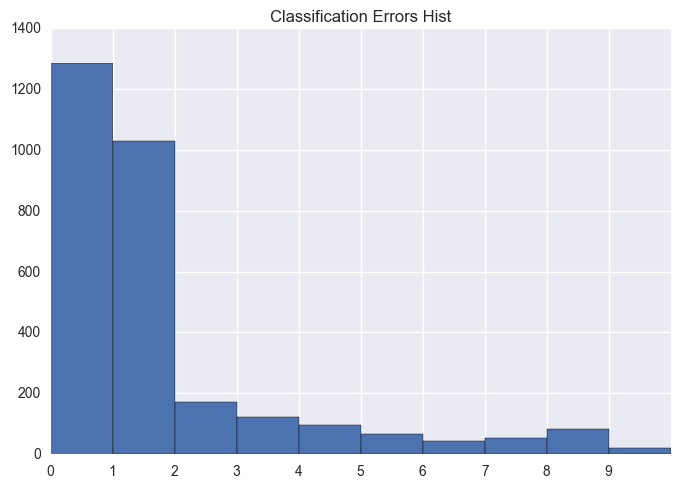

In [59]:
counts, bin_edges, _ = plt.hist(errors.total, bins=np.arange(11))
plt.xticks(np.arange(10))
plt.title('Classification Errors Hist')

In [51]:
for i, count in zip(range(len(counts)), counts):
    print '{} examples were mistaken by {}/9 classifiers'.format(int(count), i)

1284 examples were mistaken by 0/9 classifiers
1030 examples were mistaken by 1/9 classifiers
173 examples were mistaken by 2/9 classifiers
123 examples were mistaken by 3/9 classifiers
95 examples were mistaken by 4/9 classifiers
68 examples were mistaken by 5/9 classifiers
45 examples were mistaken by 6/9 classifiers
52 examples were mistaken by 7/9 classifiers
83 examples were mistaken by 8/9 classifiers
22 examples were mistaken by 9/9 classifiers


In [ ]:
errors[errors['total'] == ]